In [295]:
#!g1.1
1+1

2

In [296]:
#!g1.1
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-32GB


## Dataset

we will use Amazon product reviews dataset

In [297]:
#!g1.1

#lets load data
# to reproduce, download the data and customize this path
PATH_TO_DATA = '../data/'

In [298]:
#!g1.1
import pandas as pd

In [299]:
#!g1.1

import pandas as pd

train_df = pd.read_csv(PATH_TO_DATA + 'train.csv', index_col='id').fillna('')  # обучающий датас
valid_df = pd.read_csv(PATH_TO_DATA + 'valid.csv', index_col='id').fillna('')  # валидационный с таргетом
test_df = pd.read_csv(PATH_TO_DATA + 'test.csv', index_col='id').fillna('')  # тестовый для каггла

In [300]:
#!g1.1
train_df.shape, valid_df.shape, test_df.shape

((52057, 2), (17353, 2), (17353, 1))

In [301]:
#!g1.1
train_df.head()

,text,label
id,,
0,Sam has an everlast treat each nite before bed...,dogs
1,The product is as it says. I keep an eye on it...,dogs
2,My Kitty thinks these are treats! He loves the...,dogs
3,This is the third or fourth time that we've or...,dogs
4,Put this on both my dogs. And they are scratch...,dogs


In [302]:
#!g1.1
train_df.label.value_counts(1)

dogs                    0.537872
cats                    0.355284
fish aquatic pets       0.069001
birds                   0.020324
bunny rabbit central    0.010950
small animals           0.006570
Name: label, dtype: float64

мы видим, что больше половины наблюдений - про собак, треть про кошек, остальные относятся к рыбкам, птицам, кроликам и другим небольшим животным

#!g1.1
категории имеют существенный дисбаланс



Let's extract the sentences and labels of our training set as numpy ndarrays.

In [291]:
#!g1.1
# Get the lists of sentences and their labels.
sentences = train_df.text.values
labels = train_df.label.values

#valid_df

In [292]:
#!g1.1
# закодируем таргет

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

labels = le.fit_transform(train_df.label.values)

In [293]:
#!g1.1
le

LabelEncoder()

In [294]:
#!g1.1

labels

array([3, 3, 3, ..., 2, 3, 2])

# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.

## 3.1. BERT Tokenizer


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.


In [303]:
#!g1.1
from transformers import BertTokenizer

# попробуем облегченную модель 
# Load the BERT tokenizer. distilbert-base-uncased
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)  #стандартная модель - bert-base-uncased, 

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


Loading BERT tokenizer...






Let's apply the tokenizer to one sentence just to see the output.


In [ ]:
#!g1.1
# Print the original sentence.
print(' Original: ', sentences[10])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[10]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[10])))

## 3.3. Tokenize Dataset

Оценим максимальную длину текста

In [168]:
#!g1.1
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  2971


In [169]:
#!g1.1
# тем не менее, важно понимать распределение кол-ва токенов в последовательности:

# statistics of text length (in words)
train_df['text'].apply(lambda s: len(s.split())).describe()


count    52057.000000
mean        84.420443
std         80.027988
min          1.000000
25%         35.000000
50%         61.000000
75%        106.000000
max       2360.000000
Name: text, dtype: float64

In [171]:
#!g1.1

train_df['text'].apply(lambda s: len(s.split())).quantile(0.95), train_df['text'].apply(lambda s: len(s.split())).quantile(0.99)

(229.0, 392.0)

#!g1.1
99  персентиль - 392 токена, мы можем обрезать использовать стандартные 512, или взять 256

Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


In [172]:
#!g1.1
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.   Установили на основе анализа длины текстов
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Sam has an everlast treat each nite before bed, like a good tooth brushing. The only downside is finding a place that keeps them in stock as well as multiple flavors.
Token IDs: tensor([  101,  3520,  2038,  2019,  2412,  8523,  2102,  7438,  2169,  9152,
         2618,  2077,  2793,  1010,  2066,  1037,  2204, 11868, 12766,  1012,
         1996,  2069, 12482,  5178,  2003,  4531,  1037,  2173,  2008,  7906,
         2068,  1999,  4518,  2004,  2092,  2004,  3674, 26389,  1012,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   

## 3.4. Training & Validation Split


Divide up our training set to use 90% for training and 10% for validation.

In [173]:
#!g1.1
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

46,851 training samples
5,206 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [174]:
#!g1.1
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 64  # посмотрим, как зайдет по памяти 64

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

## 4.1. BertForSequenceClassification

OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [100]:
#!g1.1
train_df.label.nunique()  # 6 уникальных категорий

6

In [304]:
#!g1.1
from transformers import BertForSequenceClassification, AdamW, BertConfig

#НУЖНО УКАЗАТЬ КОЛ-ВО КЛАССОВ
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab. используем дистилированный берт
    num_labels = 6, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertForSequenceClassification: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.transformer.layer.1.ffn.lin2.weight', 'distilbert.transformer.layer.3.attention.k_lin.weight', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.4.output_layer_norm.bias', 'distilbert.transformer.layer.2.ffn.lin1.bias', 'distilbert.transformer.layer.5.output_layer_norm.weight', 'distilbert.transformer.layer.3.attention.out_lin.bias', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'vocab_transform.weight', 'distilbert.transformer.layer.0.sa_layer_norm.weight', 'distilbert.transformer.layer.2.attention.q_lin.weight', 'distilbert.transformer.layer.5.sa_layer_norm.bias', 'distilbert.transformer.layer.3.output_lay

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.




In [103]:
#!g1.1
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [176]:
#!g1.1
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [177]:
#!g1.1
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

> *Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing the insights and code for using validation loss to detect over-fitting!*

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

Define a helper function for calculating accuracy.

In [178]:
#!g1.1
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`


In [179]:
#!g1.1
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [182]:
#!g1.1
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    733.    Elapsed: 0:00:36.
  Batch    80  of    733.    Elapsed: 0:01:10.
  Batch   120  of    733.    Elapsed: 0:01:44.
  Batch   160  of    733.    Elapsed: 0:02:17.
  Batch   200  of    733.    Elapsed: 0:02:51.
  Batch   240  of    733.    Elapsed: 0:03:25.
  Batch   280  of    733.    Elapsed: 0:03:58.
  Batch   320  of    733.    Elapsed: 0:04:32.
  Batch   360  of    733.    Elapsed: 0:05:06.
  Batch   400  of    733.    Elapsed: 0:05:40.
  Batch   440  of    733.    Elapsed: 0:06:13.
  Batch   480  of    733.    Elapsed: 0:06:47.
  Batch   520  of    733.    Elapsed: 0:07:21.
  Batch   560  of    733.    Elapsed: 0:07:55.
  Batch   600  of    733.    Elapsed: 0:08:28.
  Batch   640  of    733.    Elapsed: 0:09:02.
  Batch   680  of    733.    Elapsed: 0:09:36.
  Batch   720  of    733.    Elapsed: 0:10:10.

  Average training loss: 0.77
  Training epcoh took: 0:10:20

Running Validation...
  Accuracy: 0.81
  Validat

Let's view the summary of the training process.

In [183]:
#!g1.1
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.77,0.54,0.81,0:10:20,0:00:26
2,0.50,0.50,0.82,0:10:18,0:00:23
3,0.41,0.42,0.84,0:10:18,0:00:23
4,0.37,0.41,0.84,0:10:19,0:00:23


In [185]:
#!g1.1
PATH_TO_DATA

'../data/'

In [187]:
#!g1.1
!pwd

/home/jupyter/work/resources/text_attacks/notebooks


In [190]:
#!g1.1

# сохраним модель!

torch.save(model.state_dict(), '../data/amzn.bin')

In [305]:
#!g1.1

#загрузим модель

device = torch.device("cuda") 
#model = TheModelClass(args, *kwargs) 
model.load_state_dict(torch.load('../data/amzn.bin')) 
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
#!g1.1


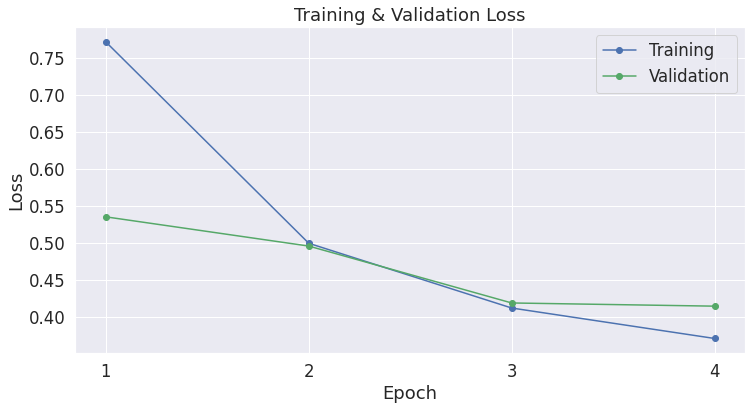

In [191]:
#!g1.1
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# 5. Performance On Test Set

### 5.1. Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [252]:
#!g1.1
le.classes_

array(['birds', 'bunny rabbit central', 'cats', 'dogs',
       'fish aquatic pets', 'small animals'], dtype=object)

In [306]:
#!g1.1
import pandas as pd

# Load the dataset into a pandas dataframe.
df = valid_df

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.text.values
labels = le.transform(df.label.values)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.  # max lenght IS SET TO 64!
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 144    #BATCH SIZE!

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 17,353



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/jupyter/.local/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## 5.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [307]:
#!g1.1
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 17,353 test sentences...
    DONE.


Now we'll combine the results for all of the batches and calculate our final MCC score.

In [308]:
#!g1.1
flat_true_labels.shape, flat_predictions.shape

((17353,), (17353,))

In [309]:
#!g1.1
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)




In [310]:
#!g1.1
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

In [ ]:
#!g1.1
print('accuracy', np.round(accuracy_score(flat_true_labels, flat_predictions),3)) #качество на тесте
print('f1', np.round(f1_score(flat_true_labels, flat_predictions, average='macro'),2)) #качество на тесте


In [259]:
#!g1.1
le.inverse_transform([3,3])

array(['dogs', 'dogs'], dtype=object)

In [260]:
#!g1.1
print('accuracy', np.round(accuracy_score(flat_true_labels, flat_predictions),3)) #качество на тесте
print('f1', np.round(f1_score(flat_true_labels, flat_predictions, average='macro'),2)) #качество на тесте


accuracy 0.829
f1 0.69


In [199]:
#!g1.1
print('accuracy', np.round(accuracy_score(flat_true_labels, flat_predictions),3)) #качество на тесте
print('f1', np.round(f1_score(flat_true_labels, flat_predictions, average='macro'),2)) #качество на тесте


accuracy 0.829
f1 0.69


In [ ]:
#!g1.1
мы видим, что модель обучалась в четыре раза дольше, тем не менее, качество получилось хуже

In [129]:
#!g1.1
print(classification_report(flat_true_labels, flat_predictions)) #качество на тесте

              precision    recall  f1-score   support

           0       0.88      0.82      0.85       353
           1       0.66      0.66      0.66       190
           2       0.82      0.79      0.81      6166
           3       0.86      0.89      0.88      9333
           4       0.93      0.89      0.91      1197
           5       0.54      0.48      0.51       114

    accuracy                           0.85     17353
   macro avg       0.78      0.76      0.77     17353
weighted avg       0.85      0.85      0.85     17353



## Проверим модель на робастность на основе адв примеров

#!g1.1

### Релизуем рецепт - textfooler

In [ ]:
#!g1.1
Почему он загружается целую вечность?

In [ ]:
#!g1.1

import textattack
model_wrapper = textattack.models.wrappers.HuggingFaceModelWrapper(model, tokenizer)

In [ ]:
#!g1.1

attack = textattack.attack_recipes.TextFoolerJin2019.build(model_wrapper)

In [ ]:
#!g1.1
attack_args = textattack.AttackArgs(num_examples=10, log_to_csv="log.csv", checkpoint_interval=5, checkpoint_dir="checkpoints", disable_stdout=True)


In [290]:
#!g1.1
valid_df['label'] = le.transform(valid_df['label'])

In [ ]:
#!g1.1
valid_df.head()

In [287]:
#!g1.1

#label_map
from datasets import load_dataset
dataset = Dataset.from_pandas(valid_df)

Dataset csv downloaded and prepared to /tmp/xdg_cache/huggingface/datasets/csv/default-6f749cb1edb1abeb/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


Using custom data configuration default-6f749cb1edb1abeb
/home/jupyter/.local/lib/python3.7/site-packages/tqdm/std.py:1133: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  for obj in iterable:
/home/jupyter/.local/lib/python3.7/site-packages/tqdm/std.py:1133: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  for obj in iterable:
Failed to deserialize variable 'dataset'. Run the following code to delete it:
  del_datasphere_variables('dataset')
Traceback (most recent call last):
  File "/kernel/lib/python3.7/site-packages/ml_kernel/state/state_protocol.py", line 283, in _load_component
    value = unpickler.load()
  File "/home/jupyter/.local/lib/python3.7/site-packages/datasets/arrow_dataset.py", line 564, in __setstate__
    pa_table = reader._read_files([data_file])
  File "/home/jupyter/.local/lib/python3.7/site-packages/datasets/arrow_reader.py", line 171, in _read

In [288]:
#!g1.1
dataset

In [ ]:
#!g1.1
attacker = textattack.Attacker(attack, dataset, attack_args)

# что на вход можно подавать в качестве аргумента для датасета? туториал подсказывает, что нужно сначала загрузить датасет в библиотеку

In [ ]:
#!g1.1
attacker.attack_dataset()

In [ ]:
#!g1.1

dataset = textattack.datasets.HuggingFaceDataset("imdb", split="test")
>>> attack = textattack.attack_recipes.TextFoolerJin2019.build(model_wrapper)
>>> # Attack 20 samples with CSV logging and checkpoint saved every 5 interval
>>> attack_args = textattack.AttackArgs(num_examples=20, log_to_csv="log.csv", checkpoint_interval=5, checkpoint_dir="checkpoints", disable_stdout=True)
>>> attacker = textattack.Attacker(attack, dataset, attack_args)
>>> attacker.attack_dataset()